## Goals

Our agent, SaleCoach, will be the ultimate personal sales enablement assistant! 🚀

SaleCoach will decide when to store valuable insights.

SaleCoach can update either a Sales Rep’s profile or a collection of Preferences (like coaching style, content format).

In addition to semantic memory, SaleCoach will also manage procedural memory such as instructions for specific campaigns or target accounts.

This allows sales reps to evolve their preferences — for example: “I now prefer short bullet-style responses during calls” or “Give me softer rebuttals for hesitant leads.”

SaleCoach will intelligently access the web (for industry/competitor updates), the local database (for CRM or deal history), and internal knowledge (playbooks, scripts via vector DB) — and decide which source best fits the rep’s query.

In [ ]:
!pip install transformers torch langchain langgraph trustcall

In [13]:
import os, getpass
from dotenv import load_dotenv

# Load variables from the .env file in the current directory
load_dotenv()

def _set_env(var: str):
    # Check if the variable is set in the OS environment
    env_value = os.environ.get(var)
    if not env_value:
        # If not set, prompt the user for input
        env_value = getpass.getpass(f"{var}: ")
    
    # Set the environment variable for the current process
    os.environ[var] = env_value

_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"


In [11]:
_set_env("OPENAI_API_KEY")

In [12]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")
_set_env("TAVILY_API_KEY")

In [8]:
_set_env('username')
_set_env('password')
_set_env('host')
_set_env('port')
_set_env('database_name')

#### Step 1 and Step 2 for creating a DB to store conversations is skipped as we are using LangGraph store for saving short term and long term memories

In [9]:
# Construct the MySQL URI
mysql_uri = f"mysql+pymysql://{os.getenv('username')}:{os.getenv('password')}@{os.getenv('host')}:{os.getenv('port')}/{os.getenv('database_name')}"

In [ ]:
from langchain_community.utilities import SQLDatabase

# Connect to the MySQL database
db = SQLDatabase.from_uri(mysql_uri)

#### Step 0: Define a Trustcall Extractor

In [14]:
from pydantic import BaseModel, Field

class Memory(BaseModel):
    content: str = Field(description="The main content of the memory. For example: User expressed interest in learning about French.")

class MemoryCollection(BaseModel):
    memories: list[Memory] = Field(description="A list of memories about the user.")

In [15]:
from trustcall import create_extractor
from langchain_openai import ChatOpenAI


# Inspect the tool calls made by Trustcall
# The Spy class is designed to monitor and record tool calls made by the chat model.
class Spy:
    def __init__(self):
        self.called_tools = []

    def __call__(self, run):
        # Collect information about the tool calls made by the extractor.
        # It traverses all runs in a depth-first manner by checking for child_runs (sub-runs) and adding them to the queue.
        q = [run]
        while q:
            r = q.pop()
            if r.child_runs:
                q.extend(r.child_runs)
            if r.run_type == "chat_model":
                self.called_tools.append(
                    r.outputs["generations"][0][0]["message"]["kwargs"]["tool_calls"]
                )

# Initialize the spy
# This creates an instance of the Spy class, ready to collect tool call data.
spy = Spy()

from langchain_ollama import ChatOllama

# # Qwen2.5:7b (Ranked 40th in BFCL Toolcalling Leaderboard)
#local_llm = "llama3-groq-tool-use"
# local_llm = "Qwen2.5:7b"
# model = ChatOllama(model=local_llm, temperature=0.0)

from langchain_openai import ChatOpenAI
import openai
openai.api_key = os.getenv('OPENAI_API_KEY')

# Initialize the model
#model = ChatOpenAI(model="o3-mini-2025-01-31")
model = ChatOpenAI(model="gpt-4o")

# Create the extractor
# The extractor is a system that uses the chat model to perform some task (e.g., extracting information) and can utilize the Memory tool.
trustcall_extractor = create_extractor(
    model,
    tools=[Memory],
    tool_choice="Memory",
    enable_inserts=True,
)

# Add the spy as a listener
# Specifies that the spy instance will be called when the extractor’s operation ends.

trustcall_extractor_see_all_tool_calls = trustcall_extractor.with_listeners(on_end=spy)

#### Step 0.1: Define classes to help with decision making of the right Tool and Memory

In [17]:

from typing import TypedDict, Literal

# Update memory tool
class UpdateMemory(TypedDict):
    """ Decision on what memory type to update """
    update_type: Literal['user', 'preferences', 'instructions']

class ToolChoice(TypedDict):
    """ Tool choice """
    tool_choice: Literal['search_web', 'search_localDB', 'search_vectorDB']


In [18]:
def extract_tool_info(tool_calls, schema_name="Memory"):
    """Extract information from tool calls for both patches and new memories.
    
    Args:
        tool_calls: List of tool calls from the model
        schema_name: Name of the schema tool (e.g., "Memory", "Preferences", "Profile")
    """

    # Initialize list of changes
    changes = []
    
    for call_group in tool_calls:
        for call in call_group:
            if call['name'] == 'PatchDoc':
                changes.append({
                    'type': 'update',
                    'doc_id': call['args']['json_doc_id'],
                    'planned_edits': call['args']['planned_edits'],
                    'value': call['args']['patches'][0]['value']
                })
            elif call['name'] == schema_name:
                changes.append({
                    'type': 'new',
                    'value': call['args']
                })

    # Format results as a single string
    result_parts = []
    for change in changes:
        if change['type'] == 'update':
            result_parts.append(
                f"Document {change['doc_id']} updated:\n"
                f"Plan: {change['planned_edits']}\n"
                f"Added content: {change['value']}"
            )
        else:
            result_parts.append(
                f"New {schema_name} created:\n"
                f"Content: {change['value']}"
            )
    
    return "\n\n".join(result_parts)

# Inspect spy.called_tools to see exactly what happened during the extraction
schema_name = "Memory"
changes = extract_tool_info(spy.called_tools, schema_name)
print(changes)

In [19]:
import uuid
from IPython.display import Image, display

from datetime import datetime
from trustcall import create_extractor
from typing import Optional
from pydantic import BaseModel, Field

from langchain_core.runnables import RunnableConfig
from langchain_core.messages import merge_message_runs, HumanMessage, SystemMessage

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, END, START
from langgraph.store.base import BaseStore
from langgraph.store.memory import InMemoryStore

from langchain_openai import ChatOpenAI

#### Step 0.2: Define different types of Schemas

In [20]:
# User profile schema
class Profile(BaseModel):
    """This is the profile of the user you are chatting with"""
    name: Optional[str] = Field(description="The user's name", default=None)
    location: Optional[str] = Field(description="The user's location", default=None)
    job: Optional[str] = Field(description="The user's job", default=None)
    connections: list[str] = Field(
        description="Personal connection of the user, such as family members, friends, or coworkers",
        default_factory=list
    )
    interests: list[str] = Field(
        description="Interests that the user has", 
        default_factory=list
    )

In [21]:
# Preference schema
class Preference(BaseModel):
    communication_style: Optional[Literal["direct", "supportive", "analytical", "storytelling"]] = Field(
        description="Preferred communication style for coaching and feedback",
        default=None
    )
    preferred_format: list[str] = Field(
        description="Preferred formats for receiving coaching content (e.g., bullet points, examples, roleplays, video snippets)",
        default_factory=list
    )
    objection_handling_style: list[str] = Field(
        description="Approach the rep prefers when handling objections (e.g., empathetic, data-driven, assertive)",
        default_factory=list
    )
    deal_stage_focus: list[str] = Field(
        description="Which stages of the sales funnel the rep wants to improve at (e.g., discovery, negotiation, closing)",
        default_factory=list
    )
    learning_goals: list[str] = Field(
        description="Specific sales skills or goals the rep is focused on (e.g., handling pricing objections, improving conversion rate)",
        default_factory=list
    )

#### Step 0.3: Create extractors

In [22]:
# Create the Trustcall extractor for updating the user profile 
profile_extractor = create_extractor(
    model,
    tools=[Profile],
    tool_choice="Profile",
)

### Flow of the agent

I will provide the user input. It will go to the Harvis_v3 node. This is the core logical component of the agent where we have a model that has the memory tool and decision tool bound. 

It will make a decision based on the input to do one of the 7 things. 

1. Update the preferences list
2. Update instructions
3. Update profile
4. Search Web
5. Search VectorDB
6. Search Local DB
7. Just respond directly.

It will use toolcalling to return a structured output that it routes to one of these 6 nodes. If the tool call is not made, it just responds directly.

#### Step 3: Define LLM

In [23]:
# Initialize the model
#model = ChatOpenAI(model="o3-mini-2025-01-31")
model = ChatOpenAI(model="gpt-4o")

#### Step 4: Create State

In [24]:
from langgraph.graph import MessagesState
from typing import Annotated, Optional
import operator

class State(MessagesState):
    current_query: str
    summary: str
    external_context: Annotated[list[str], operator.add] = []
    answer: Optional[str] = None

In [25]:
from langchain_ollama import ChatOllama

# # Qwen2.5:7b (Ranked 40th in BFCL Toolcalling Leaderboard)
# local_llm = "Qwen2.5:7b"
#local_llm = "llama3-groq-tool-use"
# model = ChatOllama(model=local_llm, temperature=0.0)

#### Prompt for Model System Profile

In [41]:
# Chatbot instruction for choosing what to update and what tools to call 
# Intuition: Look, this is the current user profile you have. Here are the preferences you have. Here are the instructions you have. Here is the type of longterm memory you are tracking.
# 


MODEL_SYSTEM_MESSAGE = """You are SaleCoach, an intelligent sales training and enablement assistant.

You maintain long-term memory that includes:
1. Sales Rep Profile (product experience, strengths, performance)
2. Preferences (coaching style, formats, tone)
3. Instructions (target accounts, special campaigns)

<profile>
{user_profile}
</profile>

<preferences>
{user_preferences}
</preferences>

Parallel Actions:
- Update memory with rep or campaign context
- Search internal CRM (search_localDB) for deal history
- Retrieve pitch templates or playbooks (search_vectorDB)
- Pull industry news or competitor moves (search_web)

Examples:
- If the rep asks: “How to pitch to CTOs in banking?” → search_vectorDB
- If they mention a stalled deal → search_localDB
- If they say, “client said competitor X offers Y” → search_web

Respond with helpful, coach-like suggestions. Use memory effectively, and adapt tone to rep's preferences."""




#### Trustcall Instructions

In [27]:
# Trustcall instruction
TRUSTCALL_INSTRUCTION = """Reflect on following interaction. 

Use the provided tools to retain any necessary memories about the user. 

Use parallel tool calling to handle updates and insertions simultaneously.

System Time: {time}"""

In [28]:
# Instructions for updating the Preferences list
CREATE_INSTRUCTIONS = """Reflect on the following interaction.

Based on this interaction, update your instructions for how to update semantic memory and procedural memory. 

Use any feedback from the user to update how they like to have items added, etc.

Your current instructions are:

<current_instructions>
{current_instructions}
</current_instructions>"""

#### Create Nodes

In [29]:
# Node definitions
def Harvis_v3(state: State, config: RunnableConfig, store: BaseStore):
    """Main decision making node that coordinates conversation flow and memory updates"""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve profile memory from the store
    namespace = ("profile", user_id)
    memories = store.search(namespace)
    if memories:
        user_profile = memories[0].value
    else:
        user_profile = None

    # Retrieve preferences memory from the store
    namespace = ("preferences", user_id)
    memories = store.search(namespace)
    preferences = "\n".join(f"{mem.value}" for mem in memories)

    # Retrieve custom instructions
    namespace = ("instructions", user_id)
    memories = store.search(namespace)
    if memories:
        instructions = memories[0].value
    else:
        instructions = ""

    # Construct a system message using the model_system_message template (defined above) to include the memories from user_profile, preferences and instructions
    # Now this system_msg has the base system prompt along with the long term memories we saved.
    system_msg = MODEL_SYSTEM_MESSAGE.format(user_profile=user_profile, user_preferences=preferences, instructions=instructions)

    # Prepare input message
    # state["messages"] holds the prior conversation in the current thread
    # SystemMessage is a LangChain library similar to HumanMessage
    # Here, we are passing the complete thread messages along with the system message with the long term memories
    messages = [SystemMessage(content=system_msg)]+state["messages"]

    # Bind toolcalling to the model (the class we defined initially)
    # In LangChain, a model with bound tools can return a response object that has a tool_calls attribute if it decides to invoke a tool.
    decision_model = model.bind_tools([UpdateMemory, ToolChoice], parallel_tool_calls=False)

    # Respond using memory as well as the chat history
    # the response could be:
    # A plain text message (if no tools are needed).
    # A message with tool calls (e.g., a request to run UpdateMemory or ToolChoice)
    response = decision_model.invoke(messages)

    return {"messages": [response]}

In [30]:
def update_profile(state: State, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("profile", user_id)

    # Retrieve the most recent memories for context
    existing_items = store.search(namespace)

    # Format the existing memories for the Trustcall extractor
    tool_name = "Profile"
    existing_memories = ([(existing_item.key, tool_name, existing_item.value)
                          for existing_item in existing_items]
                          if existing_items
                          else None
                        )

    # Merge the chat history and the instruction
    TRUSTCALL_INSTRUCTION_FORMATTED=TRUSTCALL_INSTRUCTION.format(time=datetime.now().isoformat())
    updated_messages=list(merge_message_runs(messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION_FORMATTED)] + state["messages"][:-1]))

    # Invoke the extractor
    result = profile_extractor.invoke({"messages": updated_messages, 
                                         "existing": existing_memories})

    # Save the memories from Trustcall to the store
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(namespace,
                  rmeta.get("json_doc_id", str(uuid.uuid4())),
                  r.model_dump(mode="json"),
            )
    tool_calls = state['messages'][-1].tool_calls
    return {"messages": [{"role": "tool", "content": "updated profile", "tool_call_id":tool_calls[0]['id']}]}

# This is a subtle but important point. We return a tool message to our agent indicating that its original toolcall noted in "toolcalls" to update the profile has been done. 
# This is very important. In toolcalling, when a chatmodel makes a toolcall, it expects a tool message back, verifying that the toolcall is actually performed.
# It is a very important point in toolcalling workflow communication.
# We need to ensure that whenever our agent makes a toolcall, we respond with a corresponding tool message stating, "Yes, that toolcall was made!"

In [31]:
def update_preferences(state: State, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Create a namespace tuple for storing/retrieving user preferences.
    namespace = ("preferences", user_id)

    # Fetches existing preference memories for the user from the store(Long term memory).
    existing_items = store.search(namespace)

    # Format the existing memories for the Trustcall extractor in the format (key, tool_name, value)
    tool_name = "Preference"
    existing_memories = ([(existing_item.key, tool_name, existing_item.value)
                          for existing_item in existing_items]
                          if existing_items
                          else None
                        )

    # Merge the chat history and the instruction (excluding the last message)
    # Why?: To provide the extractor with both the instruction and relevant chat context.
    TRUSTCALL_INSTRUCTION_FORMATTED=TRUSTCALL_INSTRUCTION.format(time=datetime.now().isoformat())
    updated_messages=list(merge_message_runs(messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION_FORMATTED)] + state["messages"][:-1]))

    # Initialize the spy for visibility into the tool calls made by Trustcall
    # Why?: For debugging, logging, or extracting info about what the extractor does.
    spy = Spy()
    
    # Create the Trustcall extractor for updating the Preference list 
    preference_extractor = create_extractor(
    model,
    tools=[Preference],
    tool_choice=tool_name,
    enable_inserts=True
    ).with_listeners(on_end=spy)

    # Invoke the extractor
    result = preference_extractor.invoke({"messages": updated_messages, 
                                    "existing": existing_memories})

    # Save the memories from Trustcall to the store
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(namespace,
                  rmeta.get("json_doc_id", str(uuid.uuid4())),
                  r.model_dump(mode="json"),
            )
        
    # Respond to the tool call made in task_mAIstro, confirming the update
    tool_calls = state['messages'][-1].tool_calls

    # Extract the changes made by Trustcall and add the the ToolMessage returned to task_mAIstro
    preferences_update_msg = extract_tool_info(spy.called_tools, tool_name)
    return {"messages": [{"role": "tool", "content": preferences_update_msg, "tool_call_id":tool_calls[0]['id']}]}

# Here is where the trick comes in (the last 2 lines of the code)
# Take the initial toolcall that was made ("tool_calls"), remember the function we defined earlier, "extract_tool_info"? 
# Call that with spy.called_tools, this will dump all the information about what trustcall did in terms of its patching(updating memory), into preferences_update_msg.
# We pass preferences_update_msg back into the agent. This is the KEY POINT! 
# When we pass the specific updates made by Trustcall back to the agent, the agent provides much nicer, more sane answer back to the human. 
#It really closes the loop in what trustcall is doing in terms of memory management and updating, and what the agent is communicating back to the user. 


In [32]:
# This is more like the procedural memory, which is allowing the user to specify to the agent how it wants to save Preferences.

def update_instructions(state: State, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]
    
    namespace = ("instructions", user_id)

    existing_memory = store.get(namespace, "user_instructions")
        
    # Format the memory in the system prompt
    system_msg = CREATE_INSTRUCTIONS.format(current_instructions=existing_memory.value if existing_memory else None)
    new_memory = model.invoke([SystemMessage(content=system_msg)]+state['messages'][:-1] + [HumanMessage(content="Please update the instructions based on the conversation")])

    # Overwrite the existing memory in the store 
    key = "user_instructions"
    store.put(namespace, key, {"memory": new_memory.content})
    tool_calls = state['messages'][-1].tool_calls
    return {"messages": [{"role": "tool", "content": "updated instructions", "tool_call_id":tool_calls[0]['id']}]}

# Again, we return the toolcall back indicating that the instructions have been updated. 

In [33]:
#Node to access the web
import os, getpass
from langchain_community.tools import TavilySearchResults

def search_web(state:State):
    
    """ Retrieve docs from web search """

    human_messages = [m for m in state['messages'] if isinstance(m, HumanMessage)]
    if not human_messages:
        raise ValueError("No human message found in the conversation history.")
    question = human_messages[-1].content

    # Search
    tavily_search = TavilySearchResults(max_results=3)
    search_docs = tavily_search.invoke(question)

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}">\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    # Get the tool_call_id from the last message (the AIMessage with tool_calls)
    tool_calls = state['messages'][-1].tool_calls
    tool_call_id = tool_calls[0]['id']
    return {"messages": [{"role": "tool", "content": formatted_search_docs, "tool_call_id":tool_call_id}]}

In [34]:
#Node to retrieve information from vectordb
import pinecone
from langchain_pinecone import PineconeVectorStore
from langchain_huggingface import HuggingFaceEmbeddings
import os
pc = pinecone.Pinecone(api_key=os.environ['PINECONE_API_KEY'])
index_name = "pdfdataretreival"

model_name = "sentence-transformers/bert-base-nli-mean-tokens"
embedding_model = HuggingFaceEmbeddings(model_name=model_name)

vector_store = PineconeVectorStore.from_existing_index(
    index_name=index_name,
    embedding=embedding_model,
    text_key="text"
)

def search_vectorDB(state):
    """Retrieve docs from Pinecone"""

    human_messages = [m for m in state['messages'] if isinstance(m, HumanMessage)]
    if not human_messages:
        raise ValueError("No human message found in the conversation history.")
    question = human_messages[-1].content
    
    matching_results = vector_store.similarity_search(question, k=15)

    # Convert documents to a single string
    documents_str = "\n\n".join([doc.page_content for doc in matching_results])
    
    # Define a prompt to generate the answer (assuming 'model' is defined globally)
    answer_prompt = PromptTemplate.from_template(
        """Given the following user question and retrieved documents, answer the question based on the information in the documents.

        Question: {question}
        Documents:
        {documents}
        Answer: """
    )
    
    # Create and invoke the chain
    chain = answer_prompt | model | StrOutputParser()
    result = chain.invoke({"question": question, "documents": documents_str})
    
    # Get the tool_call_id from the last message (the AIMessage with tool_calls)
    tool_calls = state['messages'][-1].tool_calls  
    tool_call_id = tool_calls[0]['id']
    return {"messages": [{"role": "tool", "content": result, "tool_call_id":tool_call_id}]}
    

c:\Users\raman\anaconda3\envs\lc-academy-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [35]:
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough
import re
from langchain_community.tools import QuerySQLDataBaseTool
from langchain.chains import create_sql_query_chain


#Node to retrieve data from SQL Database
def search_localDB(state):

    """ Node to retrieve data from local Database """

    # ✅ Correct custom prompt with chain's expected structure
    template = """Given an input question, first create a syntactically correct {dialect} query to run using these tables/columns:
    {table_info}. Return only the SQL query. Use up to {top_k} results.

    Question: {input}
    SQLQuery: """

    prompt = PromptTemplate(
        input_variables=["input", "top_k", "table_info"],
        partial_variables={"dialect": db.dialect},
        template=template
    )

    # Get state
    # Assuming llm, db, and create_sql_query_chain are already defined
    write_query = create_sql_query_chain(model, db, prompt)
    execute_query = QuerySQLDataBaseTool(db=db)

    # Function to extract the raw SQL query from the formatted response
    def extract_sql_query(response):
        pattern = r"```sql\s*(.*?)\s*```"
        match = re.search(pattern, response, re.DOTALL)
        if match:
            return match.group(1).strip()
        else:
            raise ValueError("No SQL query found in the response")

    # Define the answer prompt
    answer_prompt = PromptTemplate.from_template(
        """Given the following user question, corresponding SQL query, and SQL result, answer the user question.

    Question: {question}
    SQL Query: {query}
    SQL Result: {result}
    Answer: """
    )

    # Get the last human message
    human_messages = [m for m in state['messages'] if isinstance(m, HumanMessage)]
    if not human_messages:
        raise ValueError("No human message found in the conversation history.")
    question = human_messages[-1].content
    
    # Define the chain
    chain = (
        RunnablePassthrough.assign(query=write_query)  # Generate the formatted SQL query
        .assign(query=lambda x: extract_sql_query(x["query"]))  # Extract the raw SQL query
        .assign(result=itemgetter("query") | execute_query)  # Execute the raw SQL query
        | (answer_prompt | model | StrOutputParser())  # Generate the final answer
    )

    # Invoke the chain with a dictionary containing the question
    result = chain.invoke({"question": question})

    # Get the tool_call_id from the last message (the AIMessage with tool_calls)
    tool_calls = state['messages'][-1].tool_calls
    tool_call_id = tool_calls[0]['id']
    return {"messages": [{"role": "tool", "content": result, "tool_call_id":tool_call_id}]}

In [36]:
# Conditional edge
def route_message(state: MessagesState, config: RunnableConfig, store: BaseStore) -> Literal[END, "update_preferences", "update_instructions", "update_profile", "search_web", "search_localDB","search_vectorDB"]:

    """Reflect on the memories and chat history to decide whether to update the memory collection."""
    message = state['messages'][-1]
    if len(message.tool_calls) ==0:
        return END
    else:
        tool_call = message.tool_calls[0]
        tool_name = tool_call['name']
        if tool_name == 'UpdateMemory':
            update_type = tool_call['args']['update_type']
            if update_type == "user":
                return "update_profile"
            elif update_type == "preferences":
                return "update_preferences"
            elif update_type == "instructions":
                return "update_instructions"
            else:
                raise ValueError(f"Unknown update_type: {update_type}")
        elif tool_name == 'ToolChoice':
            tool_choice = tool_call['args']['tool_choice']
            if tool_choice == "search_web":
                return "search_web"
            elif tool_choice == "search_localDB":
                return "search_localDB"
            elif tool_choice == "search_vectorDB":
                return "search_vectorDB"
            else:
                raise ValueError(f"Unknown tool_choice: {tool_choice}")
        else:
            raise ValueError(f"Unknown tool name: {tool_name}")

#### Step 6: Add nodes to the graph

In [37]:
# Create the graph + all nodes
builder = StateGraph(MessagesState)

# Define the flow of the memory extraction process
builder.add_node(Harvis_v3)
builder.add_node(update_profile)
builder.add_node(update_instructions)
builder.add_node(search_web)
builder.add_node(search_localDB)
builder.add_node(search_vectorDB)
builder.add_node(update_preferences)

#### Step 7: Add edges (Define relationships between the nodes)

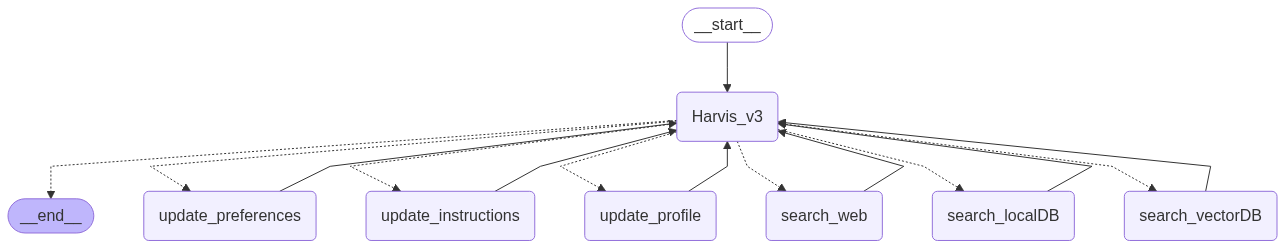

In [38]:
builder.add_edge(START, "Harvis_v3")
builder.add_conditional_edges("Harvis_v3", route_message)
builder.add_edge("update_preferences", "Harvis_v3")
builder.add_edge("update_profile", "Harvis_v3")
builder.add_edge("update_instructions", "Harvis_v3")
builder.add_edge("search_web", "Harvis_v3")
builder.add_edge("search_localDB", "Harvis_v3")
builder.add_edge("search_vectorDB", "Harvis_v3")

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# We compile the graph with the checkpointer and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

#### Step 8: Test through chat

In [44]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "11", "user_id": "11"}}

# User input to create a profile memory
#input_messages = [HumanMessage(content="My name is Robert. I live in LA with Qwen. I hit the gym everyday.")]
input_messages = [HumanMessage(content="""
I'm preparing for a call with FinEdge Inc., a mid-sized fintech company. The deal has stalled, and the last CRM update says they’re evaluating competitors like PayNova.

Can you search the web for recent news about PayNova and FinEdge.
""")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================


I'm preparing for a call with FinEdge Inc., a mid-sized fintech company. The deal has stalled, and the last CRM update says they’re evaluating competitors like PayNova.

Can you search the web for recent news about PayNova and FinEdge.

================================== Ai Message ==================================
Tool Calls:
  ToolChoice (call_MjuCQ0YaK6lRRK45b5XtCyQC)
 Call ID: call_MjuCQ0YaK6lRRK45b5XtCyQC
  Args:
    tool_choice: search_web
================================= Tool Message =================================


================================== Ai Message ==================================

I'll look up recent news on PayNova and FinEdge Inc. to provide you with the latest competitive insights. Please hold on while I gather that information.
Tool Calls:
  UpdateMemory (call_uolyMVHQkjYXla3Gu3yl7Reo)
 Call ID: call_uolyMVHQkjYXla3Gu3yl7Reo
  Args:
    update_type: instructions
==========